Using device: cuda


100%|██████████| 170M/170M [00:02<00:00, 79.1MB/s]



Training CNN with SGD...
Epoch [1/15] | Loss: 2.2619 | Acc: 14.73%
Epoch [5/15] | Loss: 1.6429 | Acc: 40.35%
Epoch [10/15] | Loss: 1.4177 | Acc: 48.86%
Epoch [15/15] | Loss: 1.2668 | Acc: 54.85%
Done SGD in 160.3s. Final Loss: 1.2668

Training CNN with Momentum...
Epoch [1/15] | Loss: 1.8943 | Acc: 29.91%
Epoch [5/15] | Loss: 1.0160 | Acc: 64.08%
Epoch [10/15] | Loss: 0.7607 | Acc: 73.38%
Epoch [15/15] | Loss: 0.6568 | Acc: 76.99%
Done Momentum in 159.4s. Final Loss: 0.6568

Training CNN with Nesterov...
Epoch [1/15] | Loss: 1.8291 | Acc: 32.90%
Epoch [5/15] | Loss: 0.9504 | Acc: 66.66%
Epoch [10/15] | Loss: 0.7248 | Acc: 74.36%
Epoch [15/15] | Loss: 0.6321 | Acc: 77.97%
Done Nesterov in 151.5s. Final Loss: 0.6321

Training CNN with AdaGrad...
Epoch [1/15] | Loss: 1.7395 | Acc: 36.42%
Epoch [5/15] | Loss: 1.1294 | Acc: 59.93%
Epoch [10/15] | Loss: 0.9672 | Acc: 65.69%
Epoch [15/15] | Loss: 0.8907 | Acc: 68.73%
Done AdaGrad in 149.7s. Final Loss: 0.8907

Training CNN with RMSProp...
Ep

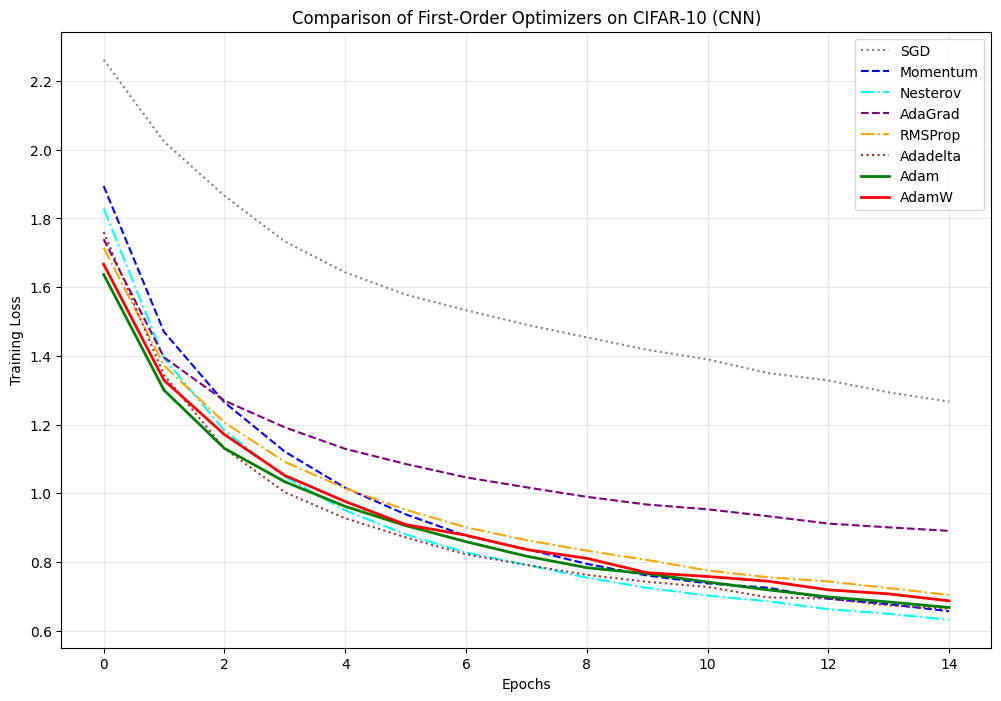

In [1]:
# ======================================================================================
# EXTENSION EXPERIMENT 2: CNN on CIFAR-10 (FULL OPTIMIZERS)
# ======================================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

# Sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Data CIFAR-10
# Chuẩn bị dữ liệu với Data Augmentation nhẹ để tránh Overfitting
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Chuẩn hóa theo thống kê của CIFAR-10
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# 2. Define Simple CNN Model (Giữ nguyên kiến trúc như bài toán 3 [cite: 1532])
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1) 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Helper function để lấy Optimizer
def get_optimizer(model, opt_name):
    # Learning rates được tinh chỉnh nhẹ dựa trên lý thuyết chương 3
    if opt_name == 'SGD': 
        # Vanilla Gradient Descent (Stochastic) 
        return optim.SGD(model.parameters(), lr=0.01)
    
    elif opt_name == 'Momentum':
        # SGD with Momentum (beta=0.9) 
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    elif opt_name == 'Nesterov':
        # Nesterov Accelerated Gradient (NAG) 
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    
    elif opt_name == 'AdaGrad':
        # AdaGrad (Adaptive Gradient) [cite: 55]
        return optim.Adagrad(model.parameters(), lr=0.01)
    
    elif opt_name == 'RMSProp':
        # RMSProp 
        return optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
    
    elif opt_name == 'Adadelta':
        # Adadelta (No learning rate needed usually, default lr=1.0) 
        return optim.Adadelta(model.parameters(), lr=1.0)
    
    elif opt_name == 'Adam':
        # Adam (Adaptive Moment Estimation) 
        return optim.Adam(model.parameters(), lr=0.001)
    
    elif opt_name == 'AdamW':
        # AdamW (Decoupled Weight Decay) - Phụ lục A 
        return optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
    
    else:
        raise ValueError(f"Optimizer {opt_name} not supported")

# 4. Training Loop
def train_cnn(opt_name, epochs=15):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, opt_name)
    
    losses = []
    print(f"\nTraining CNN with {opt_name}...")
    st = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Tính accuracy đơn giản để theo dõi
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        
        # In log mỗi 5 epoch
        if (epoch + 1) % 5 == 0 or epoch == 0:
            acc = 100 * correct / total
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")
        
    duration = time.time() - st
    print(f"Done {opt_name} in {duration:.1f}s. Final Loss: {losses[-1]:.4f}")
    return losses

# 5. Run & Compare All Optimizers
optimizers_to_test = [
    'SGD', 'Momentum', 'Nesterov', 
    'AdaGrad', 'RMSProp', 'Adadelta', 
    'Adam', 'AdamW'
]

results = {}

for opt in optimizers_to_test:
    results[opt] = train_cnn(opt, epochs=15) # Epochs=15 theo thiết lập bài toán 2 [cite: 1528]

# 6. Plotting Results
plt.figure(figsize=(12, 8))

# Định nghĩa style cho từng nhóm thuật toán để dễ nhìn
styles = {
    'SGD': {'color': 'gray', 'style': ':'},
    'Momentum': {'color': 'blue', 'style': '--'},
    'Nesterov': {'color': 'cyan', 'style': '-.'},
    'AdaGrad': {'color': 'purple', 'style': '--'},
    'RMSProp': {'color': 'orange', 'style': '-.'},
    'Adadelta': {'color': 'brown', 'style': ':'},
    'Adam': {'color': 'green', 'style': '-'},
    'AdamW': {'color': 'red', 'style': '-'}
}

for opt_name, loss_hist in results.items():
    s = styles.get(opt_name, {'color': 'black', 'style': '-'})
    plt.plot(loss_hist, label=opt_name, color=s['color'], linestyle=s['style'], linewidth=2 if 'Adam' in opt_name else 1.5)

plt.title("Comparison of First-Order Optimizers on CIFAR-10 (CNN)")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('full_optimizer_comparison.png', dpi=300)
plt.show()